**Predictive Modeling of Consumer Financial Behavior: An Analysis of Portuguese Bank Telemarketing Data**

Group consisting of Ritu, Vikrant Singh and Kay Müller

Dataset: https://archive.ics.uci.edu/dataset/222/bank+marketing

Dataset Overview Source: UCI Machine Learning Repository (Portuguese Banking Institution).

DOI: 10.24432/C5K306.
Size: 45,211 instances with 17 features
Type: Multivariate Classification.
Target Variable (y): Binary (Did the client subscribe to a term deposit? "yes" or "no").

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
df = pd.read_csv("https://raw.githubusercontent.com/kaxmarc/statistics_ml/refs/heads/main/datasets/bank-full.csv", sep=';')
df.head()


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


**Data Preprocessing Strategy**

**Feature Selection**: Curated 7 key variables (Age, Balance, Duration, etc.) based on their potential to differentiate banking behavior.

**Handling Categorical Data**: Transformed "Housing" and "Loan" status into binary indicators to allow the model to process them as mathematical distances.

**Feature Scaling**: Applied a standardization technique to ensure all variables contribute equally to the final result, preventing large numbers (like Account Balance) from overshadowing smaller numbers (like Age).

In [8]:
# Binary features
df["has_loan"] = df["loan"].map({"yes": 1, "no": 0})
df["has_housing"] = df["housing"].map({"yes": 1, "no": 0})
df["contacted_before"] = (df["previous"] > 0).astype(int)

# Selecting useful features for clustering
features = df[
    ["age", "balance", "duration", "campaign",
     "has_loan", "has_housing", "contacted_before"]
]


**Model Optimization (Finding K)**

**The Elbow Method**: Executed multiple iterations of the K-Means algorithm to measure how "tightly" the data points grouped together.

**Selection Logic**: Chose 3 Clusters because it represented the point where adding more groups provided significantly less "new" information, ensuring the segments remained distinct and easy to manage.

In [9]:
#kmeans is distance based so we need to scale the data/features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)
X_scaled[:5]

array([[ 1.60696496,  0.25641925,  0.0110161 , -0.56935064, -0.43680347,
         0.89391541, -0.47269435],
       [ 0.28852927, -0.43789469, -0.41612696, -0.56935064, -0.43680347,
         0.89391541, -0.47269435],
       [-0.74738448, -0.44676247, -0.70736086, -0.56935064,  2.2893591 ,
         0.89391541, -0.47269435],
       [ 0.5710512 ,  0.04720545, -0.64523096, -0.56935064, -0.43680347,
         0.89391541, -0.47269435],
       [-0.74738448, -0.44709091, -0.23362038, -0.56935064, -0.43680347,
        -1.11867408, -0.47269435]])

k means first going with elbow method to see number of clusters required

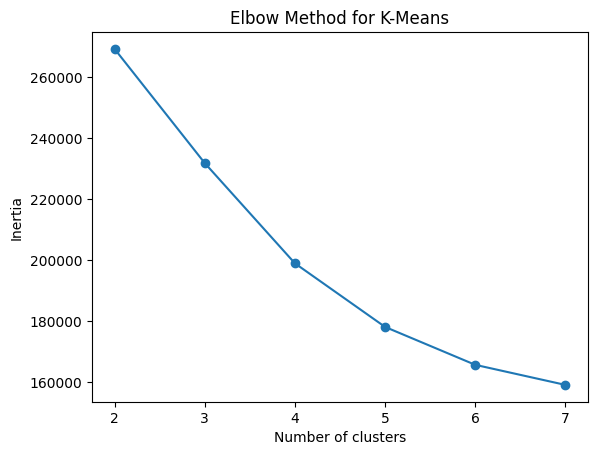

In [10]:
from sklearn.cluster import KMeans

inertia = []

for k in range(2, 8):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(2, 8), inertia, marker='o')
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method for K-Means")
plt.show()


In [11]:
#choosing 3 clusters based on elbow method
kmeans = KMeans(n_clusters=3, random_state=42)
df["cluster"] = kmeans.fit_predict(X_scaled)

df["cluster"].value_counts()


,count
cluster,
0,19984
2,16970
1,8257


In [12]:
#interpretation of clusters
cluster_summary = df.groupby("cluster")[features.columns].mean()
cluster_summary


,age,balance,duration,campaign,has_loan,has_housing,contacted_before
cluster,,,,,,,
0,39.125701,1134.338321,262.544386,2.843925,0.175991,1.000000,0.0
1,40.953131,1556.880102,260.118687,2.056195,0.136006,0.622744,1.0
2,43.060047,1535.999175,252.052092,3.013848,0.153447,0.000236,0.0


**Cluster interpretations**

**Key signals**

1. Age: ~39 (young–mid age)
2. Balance: ~1134 (lowest)
3. Campaign contacts: ~2.84
4. Housing loan: 100%
5. Loan: low (~18%)
6. Contacted before: 0%

**Cluster 0 represents customers who all have housing loans but relatively low account balances and no prior contact history. They are moderately contacted during campaigns, suggesting they may be harder to convert and require repeated outreach.**


**Interpretation**

Younger working professionals

Mostly homeowners with housing loans

Lower bank balance but longer conversations

New leads (not contacted before)

------------------------------------------------------------
**Key signals**
1. Age: ~41
2. Highest balance (~1557)
3. Campaign contacts: lowest (~2.05)
4. Housing loan: ~62%
5. Loan: lowest (~13%)
6. Contacted before: 100%



**Cluster 1 consists of customers who have been contacted previously and maintain the highest average balances. They require fewer campaign contacts, indicating higher responsiveness and stronger existing relationships with the bank.**

**Interpretation**

Financially strongest group

Already familiar with the bank

Fewer campaign calls needed

Mixed housing situation

----------------------------------------

**Key signals**

1. Oldest group (~43 years)
2. Balance: ~1536 (high)
3. Campaign contacts: highest (~3.01)
4. Housing loan: ~0%
5. Loan: moderate (~15%)
6. Contacted before: 0%


**Cluster 2 includes older customers with high balances and almost no housing loans, indicating financial independence. However, they require the highest number of campaign contacts and show no prior engagement, suggesting reluctance or selectiveness toward marketing offers.**

**Interpretation**

Older, likely renting or mortgage-free

Good financial stability

Less patient on calls

Needs more contact attempts

-----------------------------------------------------------------------------------

**Multi-Dimensional Visualization**

**Principal Component Analysis (PCA)**: Used this method to simplify our 7 complex features into a 2D map.

**Validation**: This step was used to visually confirm that the clusters identified by the computer actually form separate, logical groups in a physical space.

In [13]:
#combining models PCA + KMeans(cluster interpretation)
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df["PC1"] = X_pca[:, 0]
df["PC2"] = X_pca[:, 1]


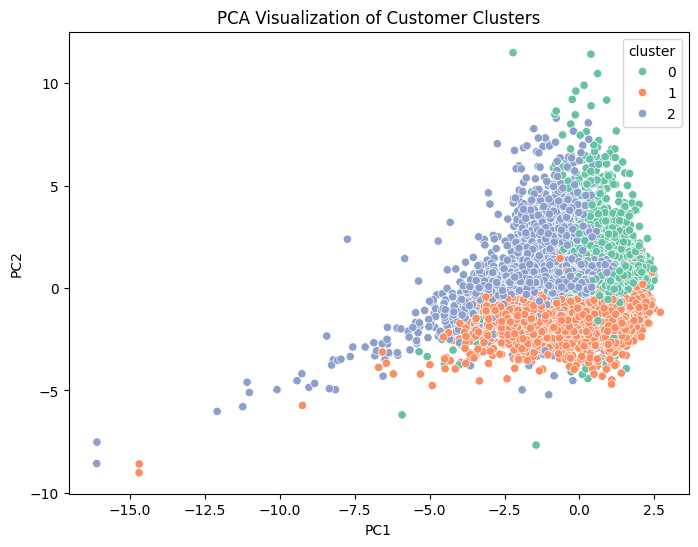

In [14]:
#visualise clusters inside pcs stage
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x="PC1",
    y="PC2",
    hue="cluster",
    data=df,
    palette="Set2"
)
plt.title("PCA Visualization of Customer Clusters")
plt.show()


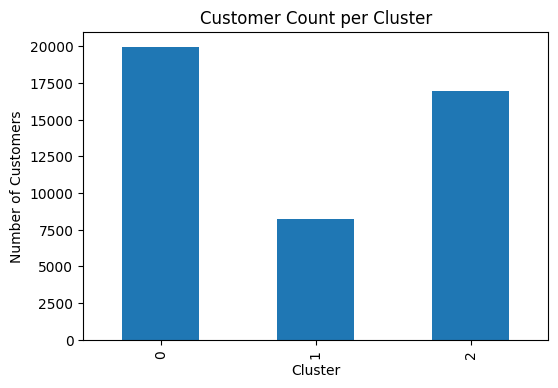

In [15]:
#cluster size distribution (checking for imbalance)
plt.figure(figsize=(6,4))
df["cluster"].value_counts().sort_index().plot(kind="bar")
plt.xlabel("Cluster")
plt.ylabel("Number of Customers")
plt.title("Customer Count per Cluster")
plt.show()


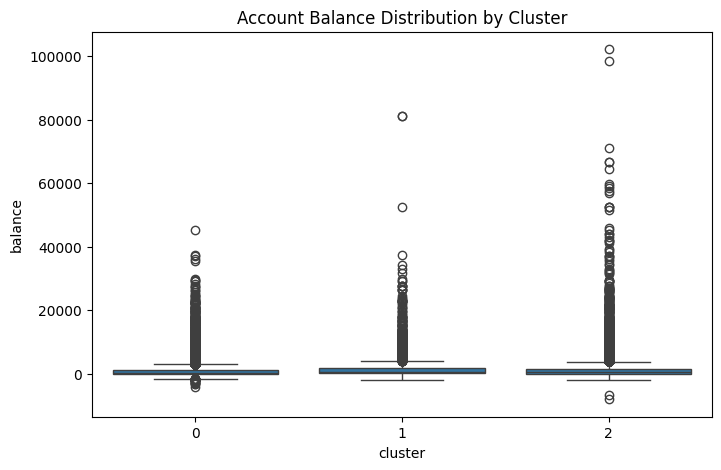

In [16]:
#boxplotn of key features by customer clusters
plt.figure(figsize=(8,5))
sns.boxplot(x="cluster", y="balance", data=df)
plt.title("Account Balance Distribution by Cluster")
plt.show()


**Creativity**

Working with **SOM** -

A SOM is a type of **Unsupervised Artificial Neural Network** that maps high-dimensional data onto a two-dimensional grid of "neurons."

In [17]:
!pip install minisom
from minisom import MiniSom

  Preparing metadata (setup.py) ... done
  Created wheel for minisom: filename=MiniSom-2.3.6-py3-none-any.whl size=13083 sha256=27af2d4284803b05012d40a2e8753951630efb9a90f48106993799715161af1a
  Stored in directory: /root/.cache/pip/wheels/84/35/b8/48b06bd8cae7187916c28a29c6daa9e0ff610647a2dfa62b97
Successfully built minisom


In [18]:
X_som = X_scaled
feature_names = list(features.columns)

print("SOM input shape:", X_som.shape)
print("Feature columns:", feature_names)

SOM input shape: (45211, 7)
Feature columns: ['age', 'balance', 'duration', 'campaign', 'has_loan', 'has_housing', 'contacted_before']


By setting a 12x12 grid, I have created a neural architecture of 144 neurons that "compete" to represent the behavioral patterns of your 45,211 customers. During the 5,000 iterations of random training, the model uses a Gaussian neighborhood function to ensure that when a neuron learns from a specific data point, its neighbors also adjust their weights, thereby preserving the topology of the high-dimensional data on a 2D map. This process—controlled by a 0.5 learning rate for initial adaptability and a seed of 42 for reproducibility—effectively "stretches" the grid over the dataset to identify non-linear clusters that traditional methods like K-Means might miss.

In [19]:
#train som
np.random.seed(42)

som_x, som_y = 12, 12  # grid size
som = MiniSom(
    x=som_x,
    y=som_y,
    input_len=X_som.shape[1],
    sigma=1.0,
    learning_rate=0.5,
    neighborhood_function="gaussian",
    random_seed=42
)

som.random_weights_init(X_som)
som.train_random(X_som, num_iteration=5000)

print(f"SOM trained: {som_x}x{som_y}, iterations=5000")

SOM trained: 12x12, iterations=5000


The U-Matrix visualizes the high-dimensional distances between neurons on a 2D plane, where the color intensity indicates the degree of similarity between neighboring units.

Each cell = a SOM node (group of similar customers)

Dark/blue areas → nodes are similar to neighbors

Bright/yellow areas → strong distance → cluster boundaries



The bright yellow regions in the middle indicate clear separations between customer groups

This means the SOM successfully discovered distinct customer segments

Unlike K-Means, boundaries are gradual, not sharp


The U-Matrix reveals clear separation zones, indicating multiple distinct customer profiles with smooth transitions between neighboring segments.

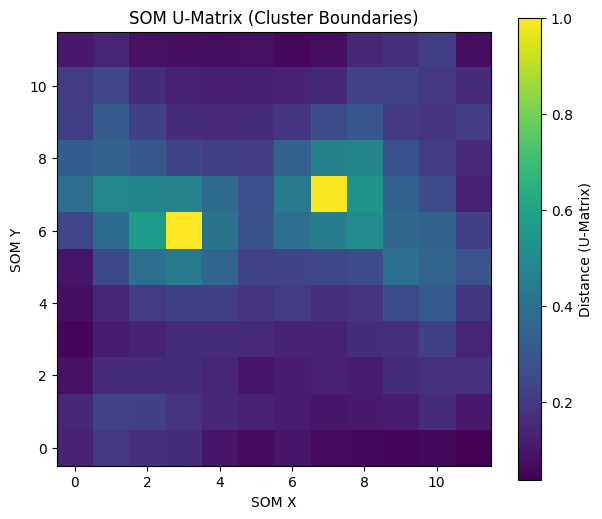

In [20]:
#U-Matrix (SOM visualization)
u_matrix = som.distance_map()

plt.figure(figsize=(7, 6))
plt.imshow(u_matrix.T, origin="lower", cmap="viridis")
plt.colorbar(label="Distance (U-Matrix)")
plt.title("SOM U-Matrix (Cluster Boundaries)")
plt.xlabel("SOM X")
plt.ylabel("SOM Y")
plt.show()

This step assigns each customer to their Best Matching Unit (BMU), which is the specific neuron on the $12 \times 12$ grid that most closely mirrors their financial profile.

In [21]:
#Assign BMUs + SOM cluster id
bmus = np.array([som.winner(x) for x in X_som])  # (n, 2)
som_cluster = bmus[:, 0] * som_y + bmus[:, 1]

df["som_cluster"] = som_cluster
df["bmu_x"] = bmus[:, 0]
df["bmu_y"] = bmus[:, 1]

print("Unique SOM nodes used:", len(np.unique(som_cluster)))
df[["som_cluster", "bmu_x", "bmu_y"]].head()

Unique SOM nodes used: 132


,som_cluster,bmu_x,bmu_y
0,49,4,1
1,96,8,0
2,118,9,10
3,38,3,2
4,134,11,2


SOM Node Occupancy (Customer Density)


Color = number of customers mapped to each node

Yellow = many customers

Dark = few or rare customers



A few nodes contain very large populations → dominant customer types

Several nodes have very low occupancy → niche or rare profiles

This shows imbalance in customer behavior, common in real marketing data



Dense nodes = mainstream customers

Sparse nodes = special targets (e.g., high-value or unusual customers)



The occupancy map shows that most customers belong to a few dominant profiles, while several rare behavioral patterns exist in low-density nodes.

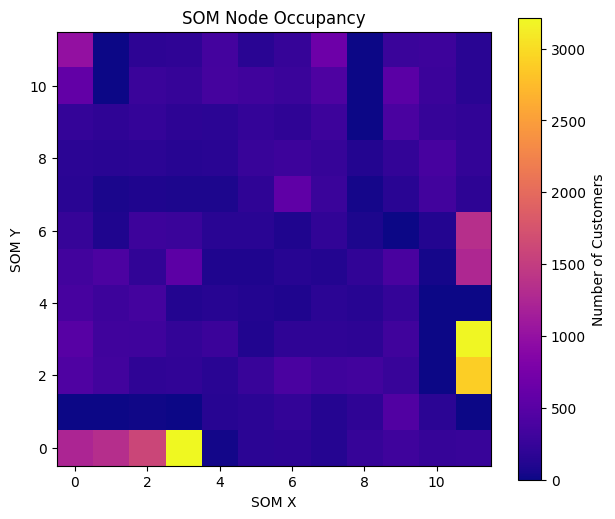

In [22]:
# 5) Occupancy map (how many customers per node)
occupancy = np.zeros((som_x, som_y), dtype=int)
for x, y in bmus:
    occupancy[x, y] += 1

plt.figure(figsize=(7, 6))
plt.imshow(occupancy.T, origin="lower", cmap="plasma")
plt.colorbar(label="Number of Customers")
plt.title("SOM Node Occupancy")
plt.xlabel("SOM X")
plt.ylabel("SOM Y")
plt.show()

**Feature Map: Age**



Red = higher age

Blue = lower age


Age changes smoothly across the map

No abrupt jumps → age alone does not form hard clusters

Age acts as a background segmentation factor



SOM is capturing gradual demographic transitions.


-----------------

**Feature Map: Balance**



Strong red hotspot near the center

Most of the map is blue (low balance)



Only a small subset of customers has very high balances

These customers are clearly separated from the majority

High-balance customers form a distinct SOM region



Financial strength is highly concentrated in a small customer segment, which is clearly isolated on the SOM.

-------------------------------------

**Feature Map: Duration**

Very strong red zones on one side of the map

Clear contrast with low-duration areas


Call duration is a major driver of segmentation

Customers with long calls are grouped together

Strongly aligns with known marketing insight: engagement matters

Shows SOM discovered behavioral structure, not just demographics



Call duration emerges as the strongest separating feature, indicating that customer engagement is a key differentiator between segments.


----------------------

**Feature Map: Campaign**



A localized red region

Most nodes are blue



Only a small group requires many campaign contacts

These customers may be:

hard to convince

or repeatedly targeted without success


High campaign intensity does not apply to most customers and characterizes a specific behavioral subgroup.

---------------------



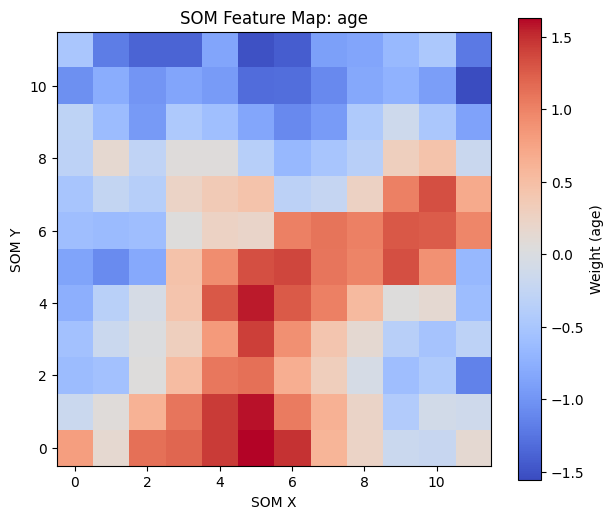

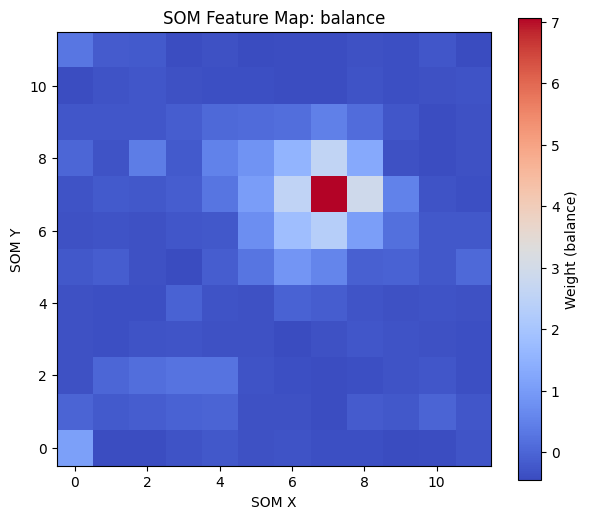

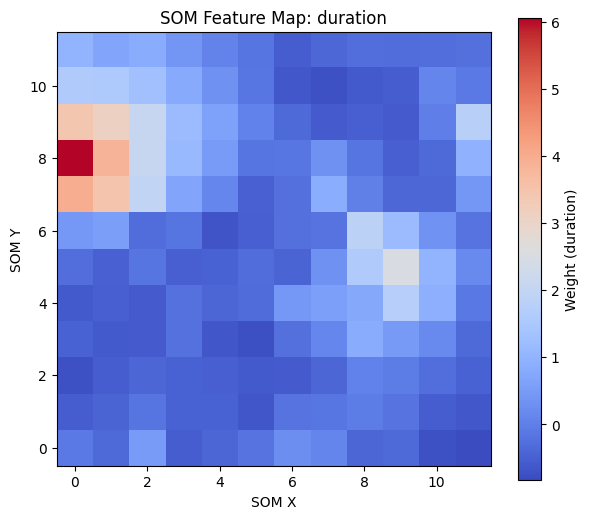

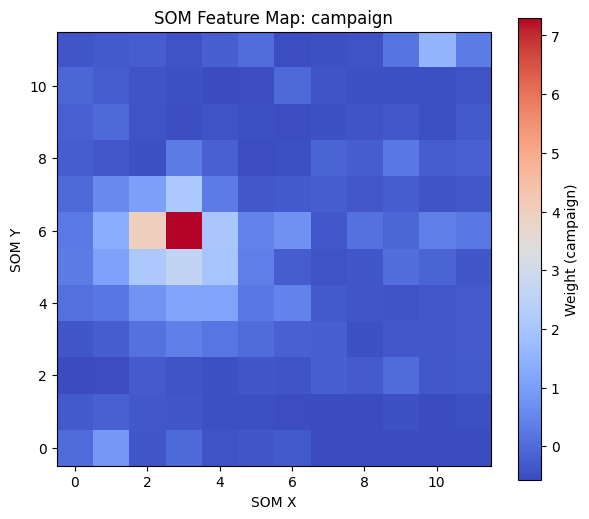

In [23]:
# 6) Feature maps
def plot_som_feature(feature_name):
    if feature_name not in feature_names:
        raise ValueError(f"{feature_name} not in feature_names.")
    idx = feature_names.index(feature_name)
    w = som.get_weights()[:, :, idx]

    plt.figure(figsize=(7, 6))
    plt.imshow(w.T, origin="lower", cmap="coolwarm")
    plt.colorbar(label=f"Weight ({feature_name})")
    plt.title(f"SOM Feature Map: {feature_name}")
    plt.xlabel("SOM X")
    plt.ylabel("SOM Y")
    plt.show()

for f in ["age", "balance", "duration", "campaign"]:
    if f in feature_names:
        plot_som_feature(f)


In [24]:
# 7) Simple SOM cluster profiling
som_summary = df.groupby("som_cluster")[feature_names].mean()
som_summary.head(10)


,age,balance,duration,campaign,has_loan,has_housing,contacted_before
som_cluster,,,,,,,
0,51.779839,5016.144355,207.970968,2.376613,0.000000,0.000000,0.176613
2,34.034803,281.909513,69.262181,1.113689,0.000000,1.000000,0.294664
3,34.881633,234.695918,139.355102,1.753061,0.000000,1.000000,0.200000
4,32.754011,412.133690,88.267380,3.275401,0.000000,1.000000,0.187166
5,31.510386,714.020772,188.071217,4.083086,0.000000,1.000000,0.166172
6,33.904959,403.657025,386.979339,3.789256,0.000000,1.000000,0.140496
7,39.164474,753.677632,1254.190789,3.118421,1.000000,0.664474,0.105263
8,41.167630,1589.427746,2017.040462,2.242775,0.057803,0.606936,0.132948
9,38.378151,1291.470588,1216.168067,2.478992,0.000000,0.000000,0.134454


**Conclusion**

This project proves that when we use tools like PCA and Neural Networks to visualize the "hidden" patterns in our data, we can make decisions that are not just statistically sound, but also more human and effective.